PNN accuracy matrix:
[[0.8859999775886536], [0.8859999775886536, 0.9421428442001344], [0.8859999775886536, 0.9421428442001344, 0.9169999957084656], [0.8859999775886536, 0.9421428442001344, 0.9169999957084656, 0.9141666889190674], [0.8859999775886536, 0.9421428442001344, 0.9169999957084656, 0.9141666889190674, 0.9121428728103638]]
EWC accuracy matrix:
[[0.8859999775886536], [0.722000002861023, 0.9435714483261108], [0.6620000004768372, 0.8707143068313599, 0.9419999718666076], [0.6159999966621399, 0.8064285516738892, 0.9235000014305116, 0.9358333349227904], [0.6380000114440918, 0.7621428370475769, 0.890999972820282, 0.8999999761581421, 0.9296428561210632]]
ER accuracy matrix:
[[0.8859999775886536], [0.8859999775886536, 0.9070000052452089], [0.9435714483261108, 0.9421428442001344, 0.8970000147819519], [0.9235714077949524, 0.9365000128746032, 0.9169999957084656, 0.8320000171661377], [0.9314285516738892, 0.9434999823570251, 0.944166660308838, 0.9141666889190674, 0.8510000109672546]]
None acc

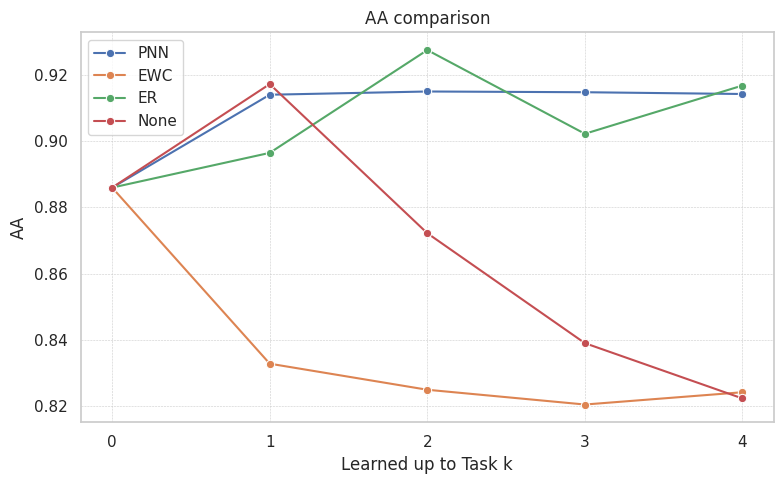

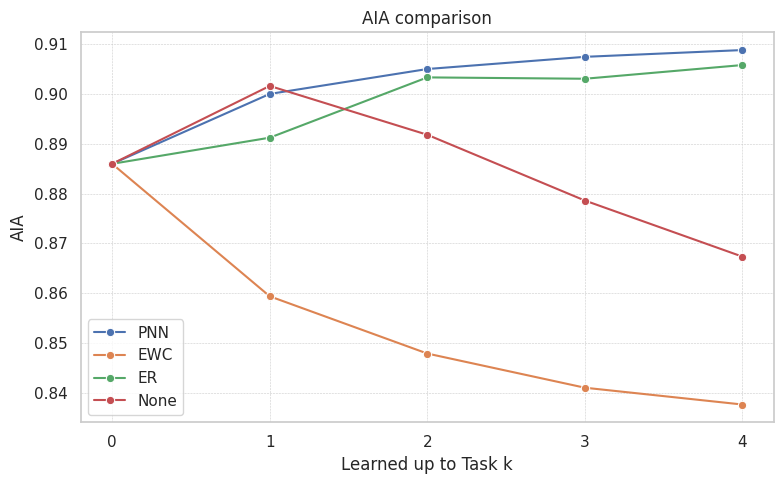

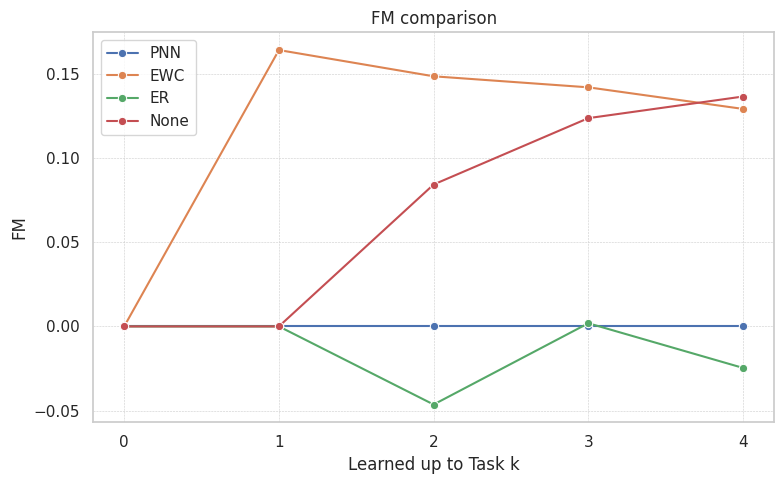

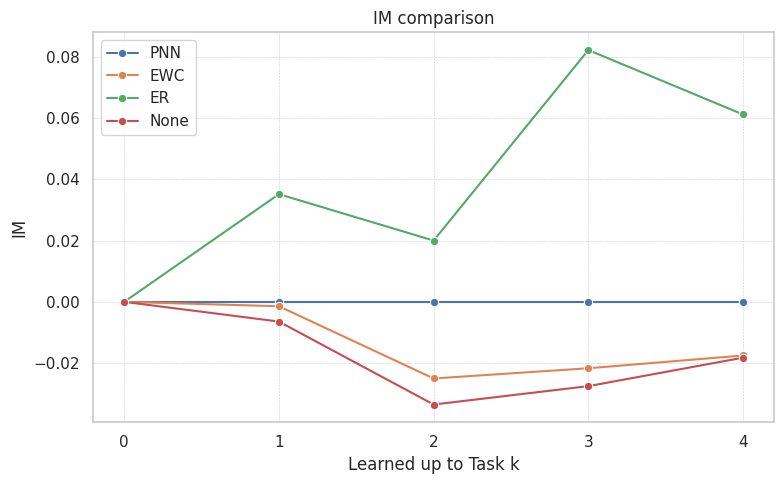

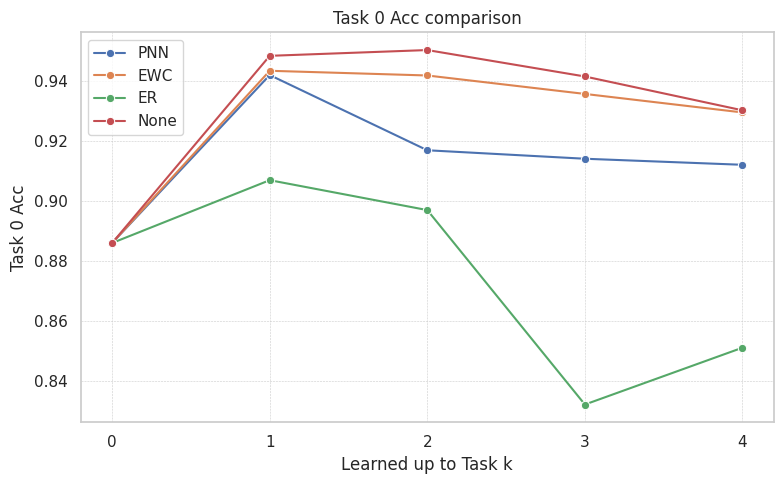

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- ファイルパス（手法ごとにCSVを用意） ---
csv_files = {
    "PNN": "/work/csv/uci-har/cil-pnn.csv",
    "EWC": "/work/csv/uci-har/cil-ewc/lambda500.csv",
    "ER": "/work/csv/uci-har/cil-er/mem3000_bs64.csv",
    "None": "/work/csv/uci-har/cil/ltc_ncps.csv",
}

joint_csv = "/work/csv/uci-har/cil-joint/ltc_ncps.csv"  # Joint baseline

# --- 指標計算関数 ---
def compute_metrics(acc_matrix: np.ndarray, joint_acc: np.ndarray | None = None):
    num_tasks = 5
    AA_list, AIA_list = [], []
    for k in range(num_tasks):
        current_accs = acc_matrix[k][: k + 1] if k < len(acc_matrix) else []
        AA_k = float(np.mean(current_accs)) if len(current_accs) > 0 else 0.0
        AA_list.append(AA_k)
        AIA_k = float(np.mean(AA_list)) if len(AA_list) > 0 else 0.0
        AIA_list.append(AIA_k)

    # FM (forgetting) — make length == num_tasks, FM[0]=0.0
    fm_list = []
    if num_tasks == 0:
        fm_list = []
    else:
        fm_list = [0.0]
        for k in range(1, num_tasks):
            forgetting_sum = 0.0
            for j in range(k):
                # collect past accuracies on task j for times l in [j, k-1]
                past_accs = []
                for l in range(j, k):
                    if l < len(acc_matrix) and j < len(acc_matrix[l]):
                        past_accs.append(acc_matrix[l][j])
                max_past_acc = max(past_accs) if past_accs else 0.0
                current_acc = acc_matrix[k][j] if (k < len(acc_matrix) and j < len(acc_matrix[k])) else 0.0
                forgetting_sum += (max_past_acc - current_acc)
            fm_list.append(forgetting_sum / k if k > 0 else 0.0)

    # IM (idealized marginal) : joint_acc[k] - acc_matrix[k][k]
    im_list = []
    for k in range(num_tasks):
        if joint_acc is not None and k < len(joint_acc):
            cl_acc_k = acc_matrix[k][k] if (k < len(acc_matrix) and k < len(acc_matrix[k])) else np.nan
            im_list.append(joint_acc[k] - cl_acc_k)
        else:
            im_list.append(np.nan)

    results=[]

    for k in range(num_tasks):
        results.append({
            'Task': k,
            'AA': AA_list[k],
            'AIA': AIA_list[k],
            'FM': fm_list[k],
            'IM': im_list[k],
            'Task 0 Acc': acc_matrix[k][k]
        })

    metrics_df = pd.DataFrame(results)
    return metrics_df

# --- Joint baselineの読み込み ---
if os.path.exists(joint_csv):
    df_joint = pd.read_csv(joint_csv)
    joint_acc = df_joint["テスト精度 (Test Acc)"].values
else:
    joint_acc = None

# --- 全手法のmetrics計算 ---
all_metrics = {}

for method, path in csv_files.items():
    if not os.path.exists(path):
        print(f"{method} CSV not found: {path}")
        continue
    
    df = pd.read_csv(path)
    num_tasks = 5
    
def build_acc_matrix_pnn(df, num_tasks):
    df_pnn = pd.read_csv(csv_files["PNN"])
    num_tasks = int(df_pnn["task"].nunique())
    acc_matrix = np.zeros((num_tasks, num_tasks), dtype=float)
    original_acc = []

    for k in range(num_tasks):
        val = df_pnn.loc[df_pnn["task"] == k, "テスト精度 (Test Acc)"].values[0]
        if k == 0:
            row = [val]
        else:
            # 前タスクの精度をコピーして最後に今回の精度を追加
            row = original_acc[-1] + [val]
        original_acc.append(row)
    return original_acc

def build_acc_matrix_ewc(df, num_tasks):
    df = pd.read_csv(csv_files["EWC"])
    accuracies = df['テスト精度 (Test Acc)'].tolist()

    # acc_matrix を構築
    acc_matrix = []
    idx = 0
    for k in range(num_tasks):
        row = accuracies[idx: idx + k + 1]
        acc_matrix.append(row)
        idx += k + 1
    return acc_matrix

def build_acc_matrix_er(df, num_tasks):
    df = pd.read_csv(csv_files["ER"])
    accuracies = df['テスト精度 (Test Acc)'].tolist()

    # --- acc_matrix構築 ---
    acc_matrix = []
    idx = 0
    for k in range(num_tasks):
        row = accuracies[idx: idx + k + 1]
        acc_matrix.append(row)
        idx += k + 1

    return acc_matrix

def build_acc_matrix_none(df, num_tasks):
    df = pd.read_csv(csv_files["None"])
    accuracies = df['テスト精度 (Test Acc)'].tolist()

    # --- acc_matrix構築 ---
    acc_matrix = []
    idx = 0
    for k in range(num_tasks):
        row = accuracies[idx: idx + k + 1]
        acc_matrix.append(row)
        idx += k + 1

    return acc_matrix

for method, path in csv_files.items():
    if not os.path.exists(path):
        print(f"{method} CSV not found: {path}")
        continue
    df = pd.read_csv(path)
    num_tasks = 5
    if df_joint is not None:
        joint_acc = df_joint["テスト精度 (Test Acc)"].values[:num_tasks]
    else:
        joint_acc = None
    acc_matrix = None
    if method == "PNN":
        acc_matrix = build_acc_matrix_pnn(df, num_tasks)
    elif method == "EWC":
        acc_matrix = build_acc_matrix_ewc(df, num_tasks)
    elif method == "ER":    
        acc_matrix = build_acc_matrix_er(df, num_tasks)
    elif method == "None":
        acc_matrix = build_acc_matrix_none(df, num_tasks)
    print(f"{method} accuracy matrix:\n{acc_matrix}")
    df_metrics = compute_metrics(acc_matrix, joint_acc)
    all_metrics[method] = df_metrics            


# --- 可視化 ---
sns.set(style="whitegrid")
metrics_to_plot = ["AA", "AIA", "FM", "IM", "Task 0 Acc"]

for metric in metrics_to_plot:
    plt.figure(figsize=(8,5))
    for method, df_metric in all_metrics.items():
        sns.lineplot(data=df_metric, x="Task", y=metric, marker="o", label=method)
    plt.title(f"{metric} comparison")
    plt.xlabel("Learned up to Task k")
    plt.xticks(range(num_tasks))
    plt.grid(True, linestyle="--", linewidth=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()
